# Convolutional Neural Network Application

In [50]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

In [51]:
(X_train, y_train), (X_test, y_test) = mnist.load_data() 

The features data are between 0 and 255, normalize itt to improve optimization performance

In [52]:
X_train, X_test = X_train / 255.0, X_test / 255.0

In [53]:
print(y_train[0:5])

[5 0 4 1 9]


Make them one-hot encoded vector

In [54]:
print('Categorical Labels')
print(y_train[0:5])

# make labels one hot encoded
y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)

print("one hot encoded labels")
print(y_train[0:5])

Categorical Labels
[5 0 4 1 9]
one hot encoded labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(5, 10), dtype=float32)


In [55]:
print(y_test[0:5])

tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]], shape=(5, 10), dtype=float32)


In [56]:
print("number of training examples:", X_train.shape[0])
print("number of test examples:", X_test.shape[0])

number of training examples: 60000
number of test examples: 10000


In [57]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(50)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(50)

### Converting a 2D image into a 1D Vector

In [58]:
from tensorflow.keras.layers import Flatten
flatten = Flatten(dtype='float32')

print("original data shape")
print(X_train.shape)

print("\nflatted shape")
print(flatten(X_train).shape)

original data shape
(60000, 28, 28)

flatted shape
(60000, 784)


### Assigning bias and weights to null tensors

In [59]:
# Weight tensor
W = tf.Variable(tf.zeros([784, 10], tf.float32))

# Bias tensor
b = tf.Variable(tf.zeros([10], tf.float32))

In [60]:
def forward(x):
  return tf.matmul(x, W) + b

In [61]:
# a sample softmax calculation on an input vector
vector = [10, 0.2, 8]
softmax = tf.nn.softmax(vector)
print("softmax calculation")
print(softmax.numpy())
print("\nverifying normalization")
print(tf.reduce_sum(softmax))
print("\nfinding vector with largest value (label assignment)")
print(f"category {tf.argmax(softmax).numpy()}")


softmax calculation
[8.8075405e-01 4.8839214e-05 1.1919710e-01]

verifying normalization
tf.Tensor(1.0, shape=(), dtype=float32)

finding vector with largest value (label assignment)
category 0


Softmax is simply an exponential of each value that is also normalized. The formula is: 

$$\sigma(z_i) = \frac{e^{z_i}}{\sum{e^{z_i}}}$$

define our output layer

In [62]:
def activate(x):
  return tf.nn.softmax(forward(x))

Logistic function output is used for the classification between 2 target classes 0/1. Softmax function is generalized type of logistic func. That is, Softmax can output a multicalss categorical probability distribution.

Creating a model function for convenience.

In [63]:
def model(x):
  x = flatten(x)
  return activate(x)

## Cost function
It is a function that is used to minimize the diff between the right answers (labels) and estimated outputs by our Network. Here we use the cross entropy function, which is a popular cost function used for categorical models. THe function is defined in terms of probabilities, which is why we must used normalized vectors. It is given as:

$$ CrossEntropy = \sum{y_{Label}\cdot \log(y_{Prediction})}$$

In [64]:
def cross_entropy(y_label, y_pred):
  return (-tf.reduce_sum(y_label * tf.math.log(y_pred + 1.e-10)))
# addition of 1e-10 to prevent errors in zero calculations

# current loss function for unoptimized model
cross_entropy(y_train, model(X_train)).numpy()

138155.12

## Type of optimization: Gradient Descent
This is the part where you configure the optimizer for your Neural Network. There are several optimizers available, in our case we will use Gradient Descent because it is a well established optimizer.

In [65]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.25)

In [66]:
def train_step(x, y):
  with tf.GradientTape() as tape:
    # compute loss function 
    current_loss = cross_entropy(y, model(x))

    # compute gradient of loss
    # This is automatic, even with specialized functions
    grads = tape.gradient(current_loss, [W, b])

    # Apply SGD step to our variables W and b
    optimizer.apply_gradients(zip(grads, [W, b]))
  return current_loss.numpy()

## Training batches
Train using minibatch Gradient Descent

In [67]:
# zeroing out weights in case you want to run this cell multiple times

# weight tensor
W = tf.Variable(tf.zeros([784, 10], tf.float32))

# bias tensor 
b = tf.Variable(tf.zeros([10], tf.float32))

loss_values = []
accuracies = []
epochs = 10

for i in range(epochs):
  j = 0

  # each batch has 50 examples
  for X_train_batch, y_train_batch in train_ds:
    j+=1
    current_loss = train_step(X_train_batch, y_train_batch)
    if j % 500 == 0: # reporting intermittent batch statistics
      print(f"epoch {i} batch {j} loss: {current_loss}")
    
  # collecting statistics at each epoch... loss function
  # loss function
  current_loss = cross_entropy(y_train, model(X_train)).numpy()
  loss_values.append(current_loss) 
  correct_prediction = tf.equal(tf.argmax(model(X_train), axis=1),
                                tf.argmax(y_train, axis=1))

  # accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
  accuracies.append(accuracy)
  print(f"end of epoch {i} loss {current_loss} accuracy {accuracy}")


epoch 0 batch 500 loss: 308.78094482421875
epoch 0 batch 1000 loss: 243.8534698486328
end of epoch 0 loss 335063.8125 accuracy 0.7372833490371704
epoch 1 batch 500 loss: 270.43487548828125
epoch 1 batch 1000 loss: 239.2509765625
end of epoch 1 loss 331978.09375 accuracy 0.7415666580200195
epoch 2 batch 500 loss: 290.9518737792969
epoch 2 batch 1000 loss: 253.18972778320312
end of epoch 2 loss 325348.25 accuracy 0.7507666945457458
epoch 3 batch 500 loss: 292.71636962890625
epoch 3 batch 1000 loss: 260.5413818359375
end of epoch 3 loss 321318.6875 accuracy 0.7545333504676819
epoch 4 batch 500 loss: 289.2486877441406
epoch 4 batch 1000 loss: 242.80728149414062
end of epoch 4 loss 326882.0625 accuracy 0.750083327293396
epoch 5 batch 500 loss: 280.1681823730469
epoch 5 batch 1000 loss: 230.50213623046875
end of epoch 5 loss 321615.75 accuracy 0.7551666498184204
epoch 6 batch 500 loss: 277.458984375
epoch 6 batch 1000 loss: 230.25872802734375
end of epoch 6 loss 318383.1875 accuracy 0.759666

## Test and Plots

It is common to run intermittent diagnostics (such as accuracy and loss over entire data set) during trainng. Here we compute a summary statistic on the test dataset as well. Fitness metrics for the training data should closely match those of the test data. If the thest metrics are distinctly less favorable, this can be a sign of overfitting.

In [68]:
correct_prediction_train = tf.equal(tf.argmax(model(X_train), axis=1), tf.argmax(y_train, axis=1))
accuracy_train = tf.reduce_mean(tf.cast(correct_prediction_train, tf.float32)).numpy()

correct_prediction_test = tf.equal(tf.argmax(model(X_test), axis=1), tf.argmax(y_test, axis=1))
accuracy_test = tf.reduce_mean(tf.cast(correct_prediction_test, tf.float32))

print(f"Training accuracy {accuracy_train}")
print(f"Test accuracy {accuracy_test}")


Training accuracy 0.7582833170890808
Test accuracy 0.753600001335144


Text(0, 0.5, 'loss')

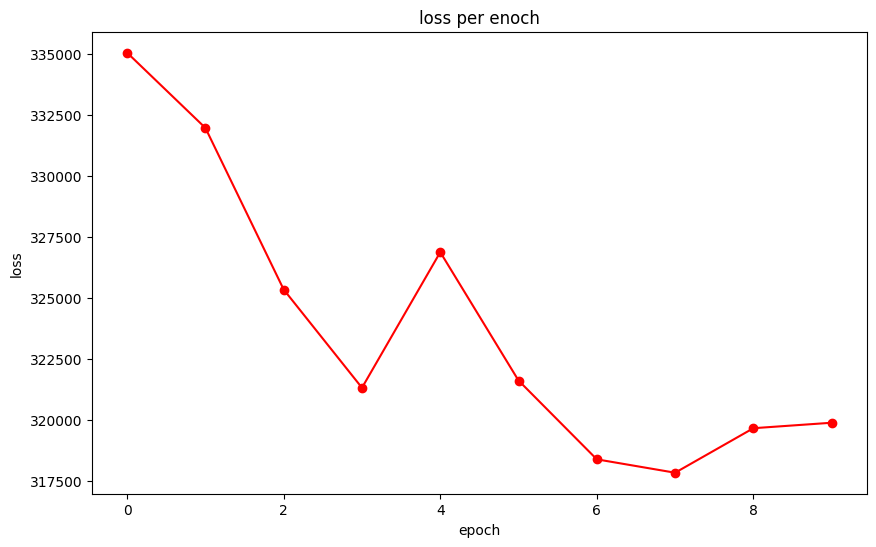

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

plt.plot(loss_values, '-ro')
plt.title("loss per enoch")
plt.xlabel("epoch")
plt.ylabel("loss")

Text(0, 0.5, 'accuracy')

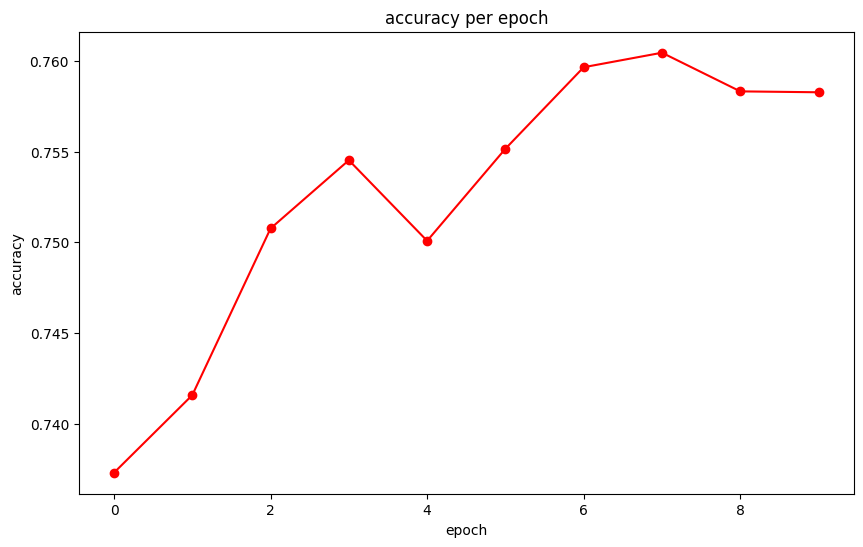

In [70]:
plt.plot(accuracies, '-ro')
plt.title("accuracy per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")

## How to improve our model?

### Several options as follow:
<li>Regularization of Neural Networks using Drop Connect</li>

<li>Multi-column Deep Neural Networks for Image Classification</li>

<li>APAC: Augmented Pattern Classification with Neural Networks</li>

<li>Simple Deep Neural Network with Dropout</li>

### In the next part we are going to explore the option:
<li>Simple Deep Neural Network with Dropout (more than 1 hidden layer)</li>

# 2nd part: Deep Learning applied on MNIST

Architecture of our network is:

<li>
(Input) -> [batch_size, 28, 28, 1] >> Apply 32 filter of [5x5]
</li>
<li>
(Convolutional layer 1) -> [batch_size, 28, 28, 32]
</li>
<li>
(ReLU 1) -> [?, 28, 28, 32]
</li>
<li>
(Max pooling 1) -> [?, 14, 14, 32]
</li>
<li>
(Convolutional layer 2) -> [?, 7, 7, 64]
</li>
<li>
(ReLU 2) -> [?, 14, 14, 64]
</li>
<li>
(Max pooling 2) -> [?, 7, 7, 64]
</li>
<li>
[fully connected layer 3] -> [1 x 1024] 
</li>
<li>
[ReLU 3] -> [1x1024]
</li>
<li>
[Drop out] -> [1x1024]
</li>
<li>
[fully connected layer 4] -> [1x10]
</li>

## Initial parameters
Create general parameters for the model

In [71]:
width = 28 # width of the image in pixels
height = 28 # height of the image in pixels
flat = width * height # number of pixels in one image
class_output = 10 # number of possible classifications for the problem (0, 1, 2, 3, .... 9)

### Converting images of the data set to tensors
The input image is 28 x 28 pixels, 1 channel (grayscale). In this case, the first dimension is the batch number of the image, and can be of any size (so we set it to -1). The second and third dimensions are width and height, and the last one is the image channels.



In [72]:
x_image_train = tf.reshape(X_train, [-1, 28, 28, 1])
x_image_train = tf.cast(x_image_train, 'float32')

x_image_test = tf.reshape(X_test, [-1 , 28, 28, 1])
x_image_test = tf.cast(x_image_test, 'float32')

# creating new dataset with reshaped inputs
train_ds2 = tf.data.Dataset.from_tensor_slices((x_image_train, y_train)).batch(50)
test_ds2 = tf.data.Dataset.from_tensor_slices((x_image_test, y_test)).batch(50)

In [73]:
# reducing data set size
x_image_train = tf.slice(x_image_train, [0,0,0,0], [1000, 28, 28, 1])
y_train = tf.slice(y_train, [0,0], [1000, 10])


## Convolutional Layer 1
**Defining kernel weight and bias**

We define a kernel here. The size of the filter/kernel is 5x5; Input channel is 1 (grayscale); and we need 32 different feature maps (here, 32 feature maps means 32 different filters are applied on each image. So the output of convolution layer would be 28x28x32). In this step, we create a filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels]

In [74]:
W_conv1 = tf.Variable(tf.random.truncated_normal([5, 5, 1, 32], stddev=0.1, seed=0))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32])) # need 32 biases for 32 outputs

In [75]:
def convolve1(x):
  return (tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)


### Apply the ReLU activation Function
In this step, we just go through all outputs convolution layer, convolve 1, and whereever a negative number occurs, we swap it out for a 0. It is ReLU activation function. Let f(x) is a ReLU activation function f(x) = max(0, x).

In [76]:
def h_conv1(x): return (tf.nn.relu(convolve1(x)))

### Apply the max pooling 
max pooling is a form of non-linear down-sampling. It partitions the input image into a set of rectangles, and then find the maximum value for that region.

Let use tf.nn.max_pool function to perform max pooling. Kernel size: 2x2 (if the window is a 2x2 matrix; it would result in one output pixel)

Strides: dictates the sliding behaviour of the kernel. In this case it will move 2 pixels everytime, thus not overlapping. The input is a matrix of size 28x28x32, and the output would be a matrix of size 14x14x32.



In [77]:
def conv1(x):
  return tf.nn.max_pool(h_conv1(x), ksize = [1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

First layer completed

### Convolutional Layer 2
**Weights and Biases of kernels**

We apply the convolution again in this layer, Lets look at the second layer kernel:

<li> 
Filter/kernel: 5x5 (25 pixels)
</li>
<li> 
Input channels: 32 (from the 1st Conv layer, we had 32 feature maps)
</li>
<li> 
64 output feature maps
</li>

Notice: here, the input image is [14x14x32], the filter is [5x5x32], we use 64 filters of size [5x5x32], and the output of the convolutional layer would be 64 convolved image, [14x14x64].

Notice: the convolution result of applying a filter of size [5x5x32] on image of size [14x14x32] is an image of size [14x14x1] that is, the convolution is functioning on volume.

In [78]:
W_conv2 = tf.Variable(tf.random.truncated_normal([5, 5, 32 ,64], stddev=0.1, seed=1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64])) # need 64 biases for 64 outputs

In [79]:
# Convolve image with weight tensor and add biases.
def convolve2(x):
  return (tf.nn.conv2d(conv1(x), W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2)

In [80]:
# Apply the ReLU activation function
def h_conv2(x): return tf.nn.relu(convolve2(x))

In [81]:
# Apply the max pooling
def conv2(x):
  return (tf.nn.max_pool(h_conv2(x), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'))

Second layer completed. 

Output: 64 matrix of [7x7]

### Fully Connected Layer
Each matrix [7x7] will be converted to a matrix of [49x1], and then all of the 64 matrix will be connected, which make an array of size [3136x1]. We will conect it into another layer of size [1024x1]. So the weight between these 2 layers will be [3136x1024].

In [82]:
# Flattening Second layer
def layer2_matrix(x): return tf.reshape(conv2(x), [-1, 7 * 7 * 64])

### Weights and Biases between layer 2 and 3

Composition of the feature map from the last layer (7x7) multiplied by the number of feature maps (64); 1027 outputs to Softmax layer

In [83]:
W_fc1 = tf.Variable(tf.random.truncated_normal([7 * 7 * 64, 1024], stddev=0.1, seed=2))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024])) # need 1024 biases for 1024 outputs

In [84]:
# Matrix Multiplication (applying weights and biases)
def fcl(x): return tf.matmul(layer2_matrix(x), W_fc1) + b_fc1

In [85]:
# Applying the ReLU activation function
def h_fc1(x): return tf.nn.relu(fcl(x))

Third layer completed

### Dropout Layer, Optional phase for reducing overfitting

It is a phase where the network "forget" some features. At each training step in a mini-batch, some units get switched off randomly so that it will not interact with the network. That is, it weights cannot be updated, nor affect the learning of other network nodes. This can be very useful for very large neural networks to prevent overfitting.

In [86]:
keep_prob=0.5
def layer_drop(x): return tf.nn.dropout(h_fc1(x), keep_prob)

Readout layer (softmax layer)
Type: Softmax, Fully Connected Layer

### Weights and Biases
In last layer, CNN takes the high-level filtered images and translate them into votes using softmax. Input channels: 1024 (neurons from the 3rd layer); 10 output features



In [87]:
W_fc2 = tf.Variable(tf.random.truncated_normal([1024, 10], stddev=0.1, seed=2)) # 1024 neurons
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10])) # 10 possibilities for digits [0, 1, 2, ... 9]


In [88]:
# Matrix Multiplication (applying weights and biases)
def fc(x): return tf.matmul(layer_drop(x), W_fc2) + b_fc2


In [89]:
# Apply the softmax activation function
def y_CNN(x):
  return tf.nn.softmax(fc(x))


# Summary of Deep Convolutional Neural Network

#### 0) Input - MNIST dataset
#### 1) Convolutional and Max-Pooling
#### 2) Convolutional and Max-Pooling
#### 3) Fully Connected Layer
#### 4) Processing - Dropout
#### 5) Readout layer - Fully Connected
#### 6) Outputs - Classified digits


## Define functions and train the model
Loss function

In [90]:
import numpy as np
layer4_test = [[0.9, 0.1, 0.1], [0.9, 0.1, 0.1]]
y_test = [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0]]
np.mean( -np.sum(y_test * np.log(layer4_test), 1))

0.10536051565782628

reduce_sum computes the sum of elements of y_ * tf.log(layer4) across second dimension of the tensor, and reduce_mean computes the mean of all elements in the tensor...

In [102]:
def cross_entrophy(y_label, y_pred):
  return (-tf.reduce_sum(y_label * tf.math.log(y_pred + 1.e-10)))

In [92]:
# Define the optimizer 
optimizer = tf.keras.optimizers.Adam(1e-4)


In [93]:
# GradientTape to define a model
variables = [W_conv1, b_conv1, W_conv2, b_conv2, W_fc1, b_fc1, W_fc2, b_fc2]

def train_step(x, y):
  with tf.GradientTape() as tape:
    current_loss = cross_entrophy(y, y_CNN(x))
    grads= tape.gradient(current_loss, variables)
    optimizer.apply_gradients( zip(grads, variables))
    return current_loss.numpy()

In [98]:
# Define prediction
correct_prediction = tf.equal(tf.argmax(y_CNN(x_image_train), axis=1), tf.argmax(y_train, axis=1))

In [100]:
# Define accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float32'))
print(accuracy.numpy())

0.084


## Run session, train

In [104]:
loss_values = []
accuracies = []
epochs = 1

for i in range(epochs):
  j=0
  # each batch has 50 examples
  for X_train_batch, y_train_batch in train_ds2:
    j+=1
    current_loss = train_step(X_train_batch, y_train_batch)
    if j % 50 == 0: # reporting intermittent batch stats
      correct_prediction = tf.equal(tf.argmax(y_CNN(X_train_batch), axis=1),
                                    tf.argmax(y_train_batch, axis=1))
      # accuracy
      accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
      print(f" epoch {i} batch {j} loss: {current_loss} accuracy: {accuracy}")

  current_loss = cross_entrophy(y_train, y_CNN(x_image_train)).numpy()
  loss_values.append(current_loss)
  correct_prediction = tf.equal(tf.argmax(y_CNN(x_image_train), axis=1),
                                tf.argmax(y_train, axis=1))
  
  # accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
  accuracies.append(accuracy)
  print(f"end of epoch {i} loss {current_loss} accuracy {accuracy}")

 epoch 0 batch 50 loss: 39.28146743774414 accuracy: 0.7200000286102295
 epoch 0 batch 100 loss: 36.92052459716797 accuracy: 0.7799999713897705
 epoch 0 batch 150 loss: 26.651084899902344 accuracy: 0.8799999952316284
 epoch 0 batch 200 loss: 17.82174301147461 accuracy: 0.9599999785423279
 epoch 0 batch 250 loss: 26.41973114013672 accuracy: 0.8999999761581421
 epoch 0 batch 300 loss: 16.76344871520996 accuracy: 0.8399999737739563
 epoch 0 batch 350 loss: 20.641620635986328 accuracy: 0.8399999737739563
 epoch 0 batch 400 loss: 18.449644088745117 accuracy: 0.9200000166893005
 epoch 0 batch 450 loss: 28.3018798828125 accuracy: 0.8399999737739563
 epoch 0 batch 500 loss: 14.329712867736816 accuracy: 0.8999999761581421
 epoch 0 batch 550 loss: 13.837871551513672 accuracy: 0.9399999976158142
 epoch 0 batch 600 loss: 26.222139358520508 accuracy: 0.8799999952316284
 epoch 0 batch 650 loss: 13.25947093963623 accuracy: 0.8999999761581421
 epoch 0 batch 700 loss: 8.399698257446289 accuracy: 0.93999

## Evaluate the model

In [105]:
j=0
accuracies = []
# evaluate accuracy by batch and average... reporting every 100th batch
for x_train_batch, y_train_batch in train_ds2:
  j+=1 
  correct_prediction = tf.equal(tf.argmax(y_CNN(x_train_batch), axis=1),
                                tf.argmax(y_train_batch, axis=1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
  accuracies.append(accuracy)
  if j % 100 ==0:
    print(f"batch {j} accuracy {accuracy}")
  
import numpy as np
print(f"accuracy of the entire set {np.mean(accuracies)}")

batch 100 accuracy 0.9599999785423279
batch 200 accuracy 0.9599999785423279
batch 300 accuracy 0.9599999785423279
batch 400 accuracy 0.9399999976158142
batch 500 accuracy 0.9399999976158142
batch 600 accuracy 0.9399999976158142
batch 700 accuracy 0.9800000190734863
batch 800 accuracy 1.0
batch 900 accuracy 0.9399999976158142
batch 1000 accuracy 0.9599999785423279
batch 1100 accuracy 0.8799999952316284
batch 1200 accuracy 0.9599999785423279
accuracy of the entire set 0.9469499588012695


## Visualization

In [106]:
kernels = tf.reshape(tf.transpose(W_conv1, perm=[2, 3, 0, 1]), [32, -1])

--2023-05-29 08:53:56--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0120EN-SkillsNetwork/labs/Week2/data/utils.py
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5097 (5.0K) [text/x-python]
Saving to: ‘utils1.py’

utils1.py           100%[===================>]   4.98K  --.-KB/s    in 0s      

2023-05-29 08:53:56 (708 MB/s) - ‘utils1.py’ saved [5097/5097]



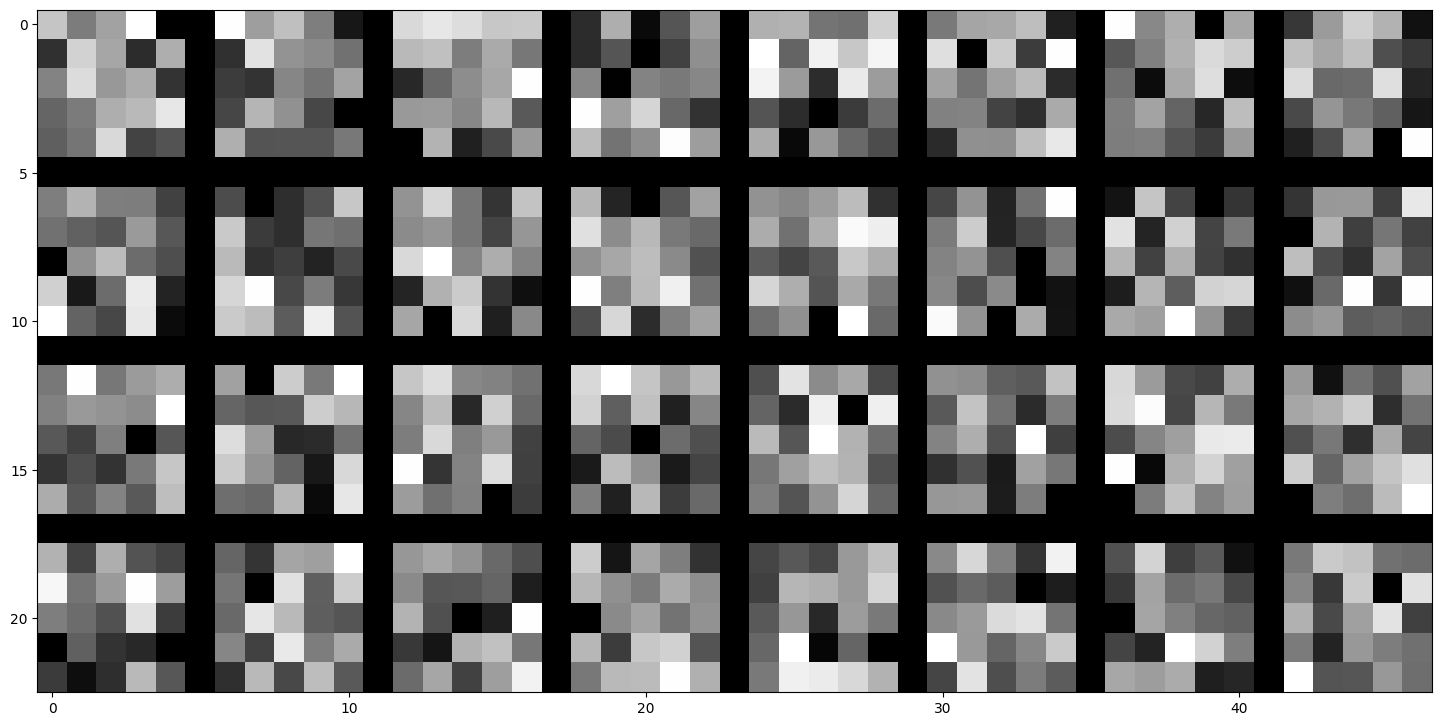

In [107]:
!wget --output-document utils1.py https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0120EN-SkillsNetwork/labs/Week2/data/utils.py
import utils1
import imp
imp.reload(utils1)
from utils1 import tile_raster_images
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
image = Image.fromarray(tile_raster_images(kernels.numpy(), img_shape=(5, 5) ,tile_shape=(4, 8), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

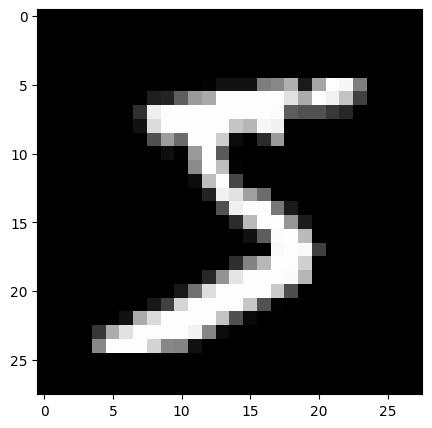

In [108]:
import numpy as np
plt.rcParams['figure.figsize'] = (5.0, 5.0)
sampleimage = [x_image_train[0]]
plt.imshow(np.reshape(sampleimage,[28,28]), cmap="gray")

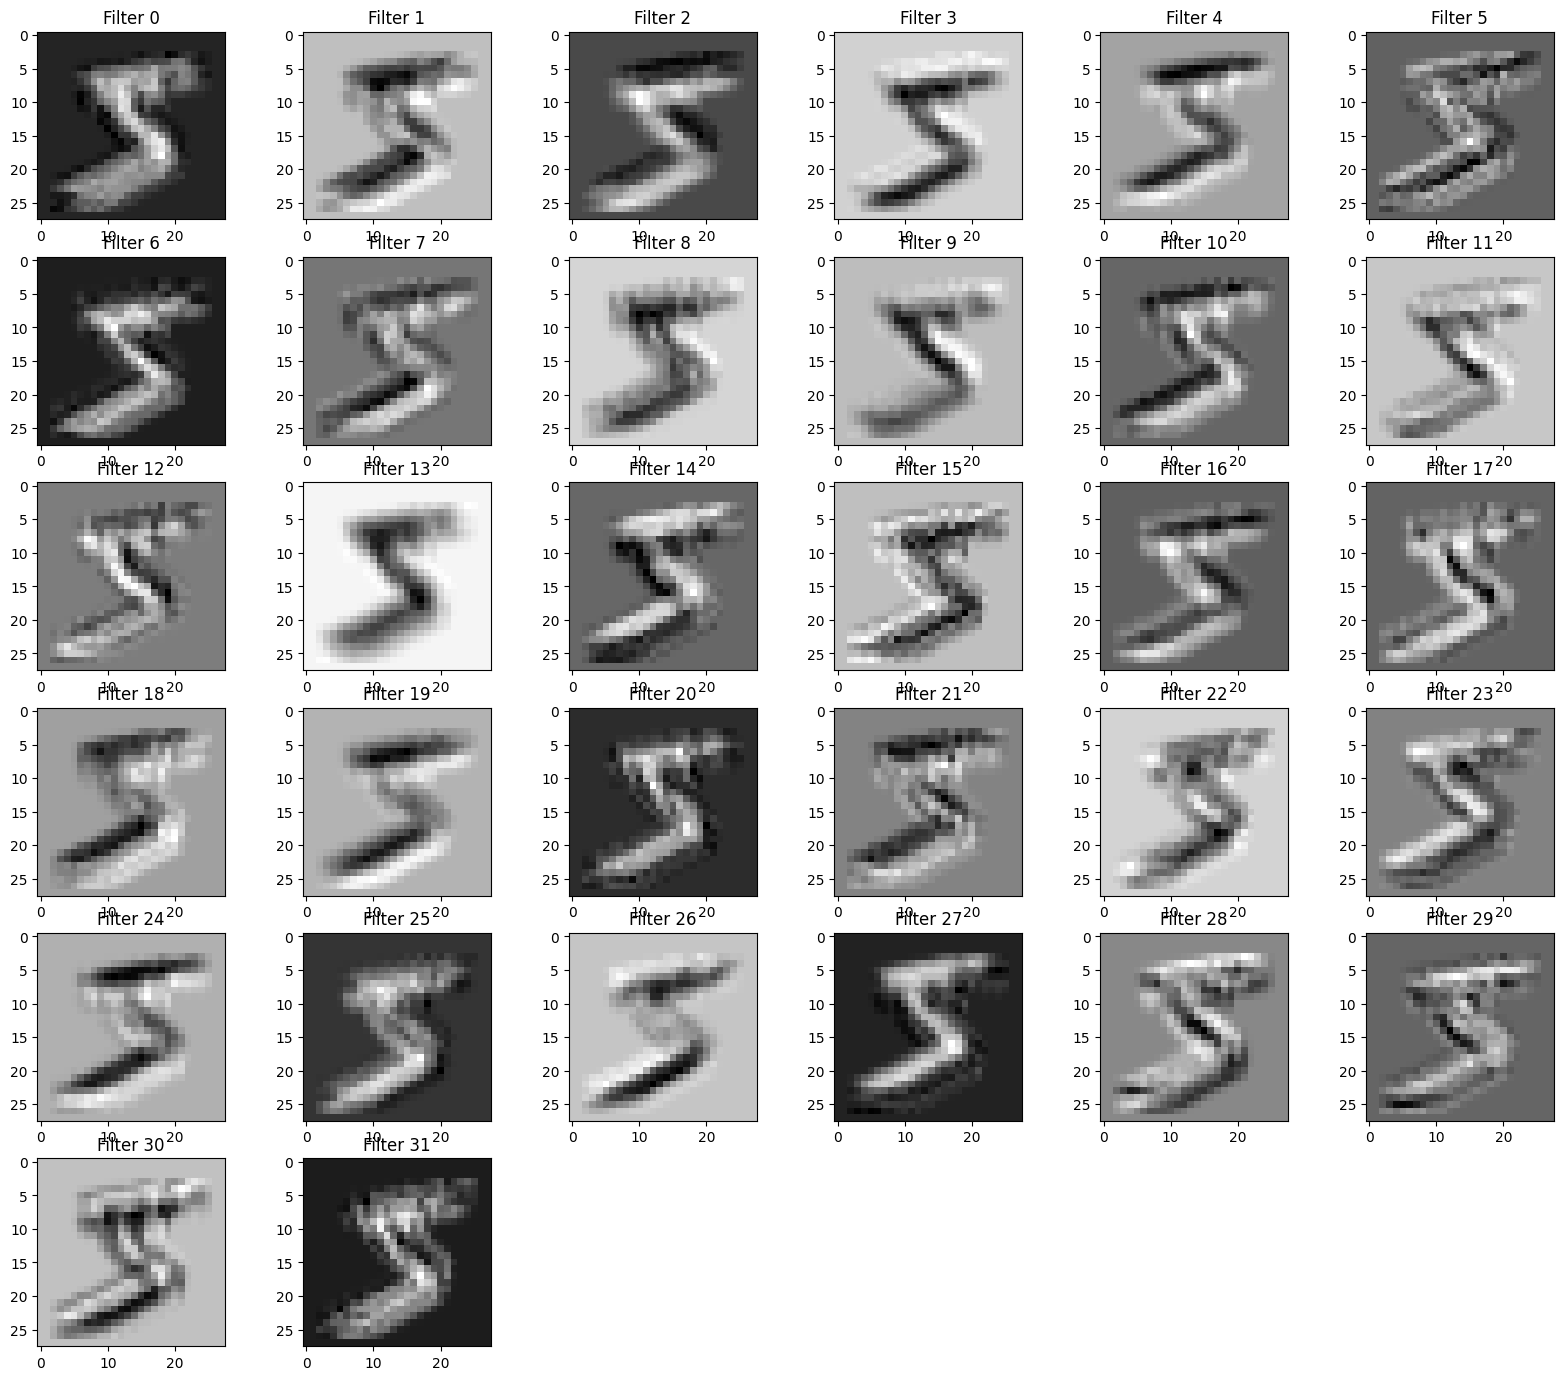

In [112]:
#ActivatedUnits = sess.run(convolve1,feed_dict={x:np.reshape(sampleimage,[1,784],order='F'),keep_prob:1.0})
keep_prob=1.0
sampleimage = np.array(sampleimage)  # Convert list to NumPy array
ActivatedUnits = convolve1(sampleimage)

                           
filters = ActivatedUnits.shape[3]
plt.figure(1, figsize=(20,20))
n_columns = 6
n_rows = np.math.ceil(filters / n_columns) + 1
for i in range(filters):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i))
    plt.imshow(ActivatedUnits[0,:,:,i], interpolation="nearest", cmap="gray")

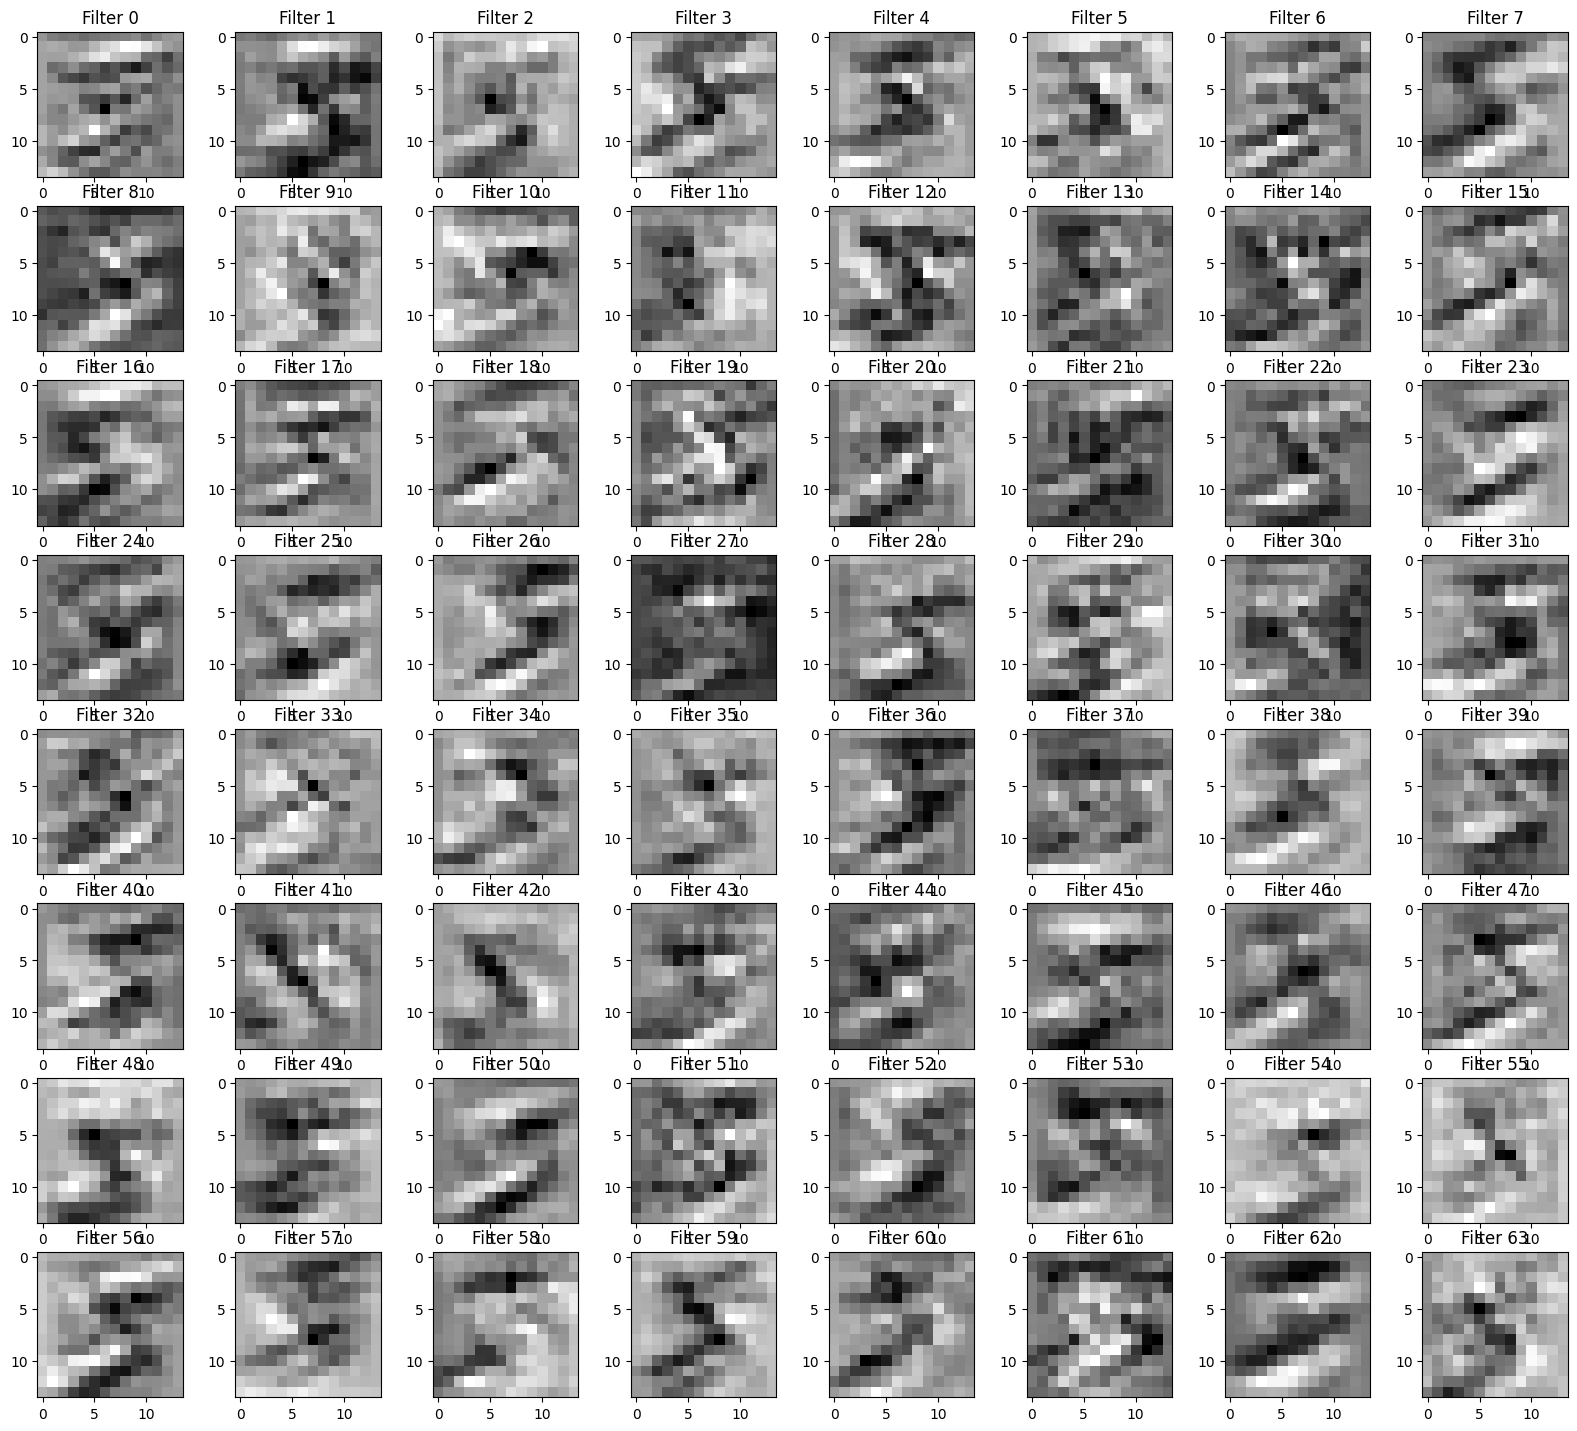

In [113]:
#ActivatedUnits = sess.run(convolve2,feed_dict={x:np.reshape(sampleimage,[1,784],order='F'),keep_prob:1.0})
sampleimage = np.array(sampleimage)
ActivatedUnits = convolve2(sampleimage)
filters = ActivatedUnits.shape[3]
plt.figure(1, figsize=(20,20))
n_columns = 8
n_rows = np.math.ceil(filters / n_columns) + 1
for i in range(filters):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i))
    plt.imshow(ActivatedUnits[0,:,:,i], interpolation="nearest", cmap="gray")